# Run

### Setup

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_scheduler, GPT2Config
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchmetrics import F1Score
pd.options.mode.copy_on_write = True

In [4]:
fpath2 = "/Users/barrychen/Desktop/IELTSWritingHelper/datasets_ready/Task_Achievement.csv"
df2 = pd.read_csv(fpath2)
df2['score'] = df2['score'].round(1)
df_filtered2 = df2[(df2['score'] > 1.5) & (df2['score'] < 12.0)]

reverse_mapping_3 = {
    3.5: 0, 4.0: 0,
    4.5: 1, 5.0: 1,
    5.5: 2, 6.0: 2,
    6.5: 3, 7.0: 3,
    7.5: 4, 8.0: 4,
    8.5: 5, 9.0: 5
}

df_filtered2['score'] = df_filtered2['score'].map(reverse_mapping_3)

df_sampled2 = df_filtered2.groupby('score').sample(
    n=290, 
    random_state=42
).reset_index(drop=True)

df_sampled2['score'] = df_sampled2['score'].astype(int)

dataset2 = Dataset.from_pandas(df_sampled2)

In [5]:
df_sampled2

,prompt,essay,text,score
0,Some people say that to prevent illness and di...,Emerging disease is a complex matter as it IS ...,The candidate has effectively addressed the gi...,0
1,Nowadays celebrities are more famous for their...,"In this present world, famous personalities a...",The essay adequately addresses the task and at...,0
2,More people decided to have children in their ...,"currently, there are more and more people make...",The essay generally addresses the task by disc...,0
3,Many people believe that the current system of...,Once every month no private vehicles a day ca...,The essay fails to address the prompt effectiv...,0
4,Some people think that instead of preventing c...,"In today's time, human activities are having a...",The essay effectively addresses the given task...,0
...,...,...,...,...
1735,some countries more and more people are becomi...,"In many nations, more and more humans are rese...",The essay effectively addresses the given task...,5
1736,Human activities have negative effects on plan...,"Nowadays, industrialisation has increased rapi...",The candidate has effectively addressed the gi...,5
1737,Nowadays people use social media to keep in to...,"In this contemporary era, the hitches allied t...",The candidate has effectively addressed the gi...,5
1738,Many customs and traditional ways of behaviour...,The vibrancy of modern life has led to debates...,The candidate effectively addresses the task b...,5


In [4]:
dataset2

Dataset({
    features: ['prompt', 'essay', 'text', 'score'],
    num_rows: 1740
})

### Fine tune the model

#### Trial #1 (8 labels)

In [5]:
num_labels_2 = 8

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token
configuration2.num_labels = num_labels_2  # Update the number of labels

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", 
    config=configuration2, 
    ignore_mismatched_sizes=True
).to(device2)

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer2(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["prompt", "essay", "text"])
tokenized_datasets2 = tokenized_datasets2.rename_column("score", "labels")
tokenized_datasets2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels2 = tokenized_datasets2["labels"]

# Get the unique labels
unique_labels2 = np.unique(labels2)

# Store the indices for each label
label_to_indices2 = {label: np.where(labels2 == label)[0] for label in unique_labels2}

# Lists to hold the train and validation indices
train_indices2 = []
val_indices2 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices2.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx2 = int(0.8 * len(indices))
    train_indices2.extend(indices[:split_idx2])
    val_indices2.extend(indices[split_idx2:])

# Convert indices to tensors
train_indices2 = torch.tensor(train_indices2)
val_indices2 = torch.tensor(val_indices2)

# Create Subsets for train and validation datasets
train_dataset2 = Subset(tokenized_datasets2, train_indices2)
eval_dataset2 = Subset(tokenized_datasets2, val_indices2)

# Dataloaders
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=num_labels_2, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Harshad018/trained-gpt2-tweet-analysis and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 28%|██▊       | 147/522 [1:44:02<4:23:36, 42.18s/it]

KeyboardInterrupt: 

#### Trial #2 (6 labels)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Harshad018/trained-gpt2-tweet-analysis and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 174/522 [2:11:32<4:03:52, 42.05s/it]

Epoch 1/3: train loss 1.8470, val loss 1.6775, val accuracy 0.2459


 67%|██████▋   | 348/522 [4:12:18<1:36:00, 33.10s/it]  

Epoch 2/3: train loss 1.5982, val loss 1.5916, val accuracy 0.2422


100%|██████████| 522/522 [5:36:22<00:00, 27.52s/it]  

Epoch 3/3: train loss 1.5265, val loss 1.5436, val accuracy 0.3196


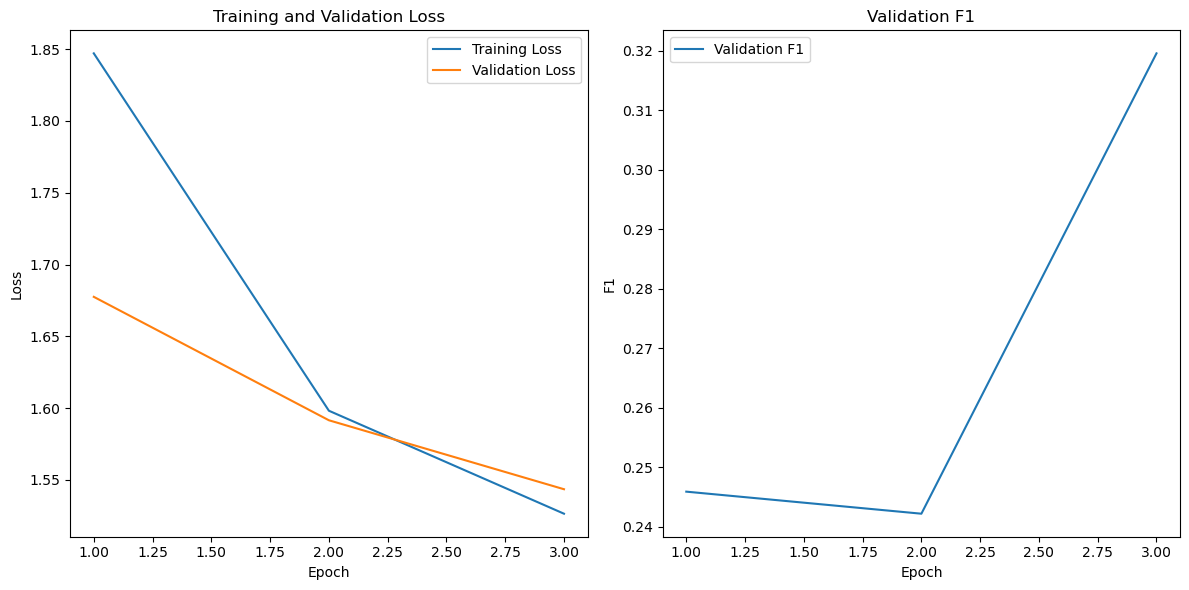

Final validation F1: 0.3196


In [6]:
num_labels_2 = 6

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token
configuration2.num_labels = num_labels_2  # Update the number of labels

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", 
    config=configuration2, 
    ignore_mismatched_sizes=True
).to(device2)

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer2(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["prompt", "essay", "text"])
tokenized_datasets2 = tokenized_datasets2.rename_column("score", "labels")
tokenized_datasets2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels2 = tokenized_datasets2["labels"]

# Get the unique labels
unique_labels2 = np.unique(labels2)

# Store the indices for each label
label_to_indices2 = {label: np.where(labels2 == label)[0] for label in unique_labels2}

# Lists to hold the train and validation indices
train_indices2 = []
val_indices2 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices2.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx2 = int(0.8 * len(indices))
    train_indices2.extend(indices[:split_idx2])
    val_indices2.extend(indices[split_idx2:])

# Convert indices to tensors
train_indices2 = torch.tensor(train_indices2)
val_indices2 = torch.tensor(val_indices2)

# Create Subsets for train and validation datasets
train_dataset2 = Subset(tokenized_datasets2, train_indices2)
eval_dataset2 = Subset(tokenized_datasets2, val_indices2)

# Dataloaders
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=num_labels_2, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [7]:
modelsavename2 = "gpt2_1740_ep3_3196.pt"

# Save the model's state_dict
with open(modelsavename2, "wb") as f:
    torch.save(model2.state_dict(), f)

print(f"Model saved as {modelsavename2}")

Model saved as gpt2_1740_ep3_3196.pt


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

modelsavename = "gpt2_1740_ep3_3196.pt" 

configuration = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration.pad_token_id = configuration.eos_token_id  # Use eos_token_id as the pad token
configuration.num_labels = 6

tokenizer = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token

model = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", config=configuration, ignore_mismatched_sizes=True
).to(device)

model.load_state_dict(torch.load(modelsavename))
model.to(device)

print(f"Model loaded from {modelsavename}")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Harshad018/trained-gpt2-tweet-analysis and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from gpt2_1740_ep3_3196.pt


/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_73625/602005580.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelsavenam

In [9]:
def get_class(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
#   probs = softmax(logits, dim=1)

  # Map classes to polarity values
#   polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
#   polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  return predicted_class


**Labelling:**

* 0->3.5 - 4.0
* 1->4.5 - 5.0
* 2->5.5 - 6.0
* 3->6.5 - 7.0
* 4->7.5 - 8.0
* 5->8.5 - 9.0

task achieve: 6.5

In [10]:
input_text = """Prompt: Today people are surrounded by advertising. This affects what people think is important and has a negative impact on people's lives. To what extent do you agree or disagree?

Essay: In this digital world, people are encircled with various types of advertisements. It is omnipresent for all, TV adverts, Social Media Marketing, billboards, Personal advertisements and many more diverse ways. while this phenomenon is escalating to extremely new level, people are in influence of it. In my view, it has more positive effects than harmful.

Because of advertisements, people are aware of current products in market. At some extent, it educates the people and provides the knowledge. For an instance, In India serious disease like  polio is no more and the major success goes to awareness campaign help by famous personality with the use of digital marketing and TV advertisements. Moreover, to bind user with interest usually companies display various new idea and it add major value in entertainment world.

However, the critical impacts are also not avoidable.Firstly, it exposes kids and young generation towards the violence and  inappropriate content sometime. Secondly, Advertisements with various discounts and offers, make people lure to do impulsive shopping. Increasing obesity is also one of consequence of advertisement of junk food. In addition, few times people get influenced by various advertisings and tend to work more to achieve never ending desire of buying stuff, this approach add up to the stress and frustration. What more, kids might suffer from harmful psychological effects when their parents are unable to afford various products shown in advertisements.

To put this in a nutshell, I can say that advertisement is beneficial phenomenon with a number of insignificant drawbacks. In my view, negative advertising effects can be lowered with help of government using stringent approach and awareness campaigns.

Comment: The candidate has adequately addressed the given task by discussing the positive and negative impacts of advertising on people's lives. They have provided relevant arguments and examples to support their claims. However, some aspects of the task, such as the impact on people's values and priorities, could have been explored in more depth. Overall, the candidate has demonstrated a good understanding of the topic and has fulfilled the requirements of the task.
"""

pred_class = get_class(input_text)
print(pred_class)

5


task achieve: 8.5

In [11]:
input_text = """Prompt: Some people think that children should be taught at school to recycle materials and avoid waste. Other people believe that children should be taught this at home. Discuss both opinions and give your own opinion.

Essay: Green energy is been regarded as the future energy for mankind, moreover,the fundamentals of achieving the same rely on reprocessing the waste. While some argue this should be educated at school level and others would like this initiative done from their homes. In this essay, we shall discuss both views and state my opinion.

On one hand, schools have been institutional in developing children cognitive skills therefore all good behaviours are cultivated here. While waste management is a profound topic and requires an in-depth analysis of how the process works or implemented. Furthermore, tutors have authority over their pupils hence they pick up subject matters efficiently. Educational institute emphasis on reusing most of the resources at school, adding to this, student comprehend the reason and significance of reducing waste such as plastic and glass. For instance, Science as a subject, demonstrates the impact of plastic and non-biodegradable materials on earth’s soil, as these take up nearly million years to decompose, consequently converting these materials to toxic and destroying mother nature.

On the other hand, young people often look up to their parents as inspiration to learn life skills. As they spend quality time at home, all behavioural attributes of kids are related to  them, so they should bring upon the habits of recycling waste at home. For example, when parents bring thumb rule of segregating waste at their homes, children at young age practice to keep waste as per the category and this behaviour can be carried across at various places like parks, social events, and public transport. As a result, children are instilled with the habit of re-cycling and segregating waste at an early age

To conclude, education on recycling waste can be beneficial as it explains the impacts on the environment and what could be done to avoid this catastrophe. Also,parenting should ensure their children learn the habit of separating waste at home. In my opinion, both methodologies must be implemented to have a better future.

Comment: The candidate effectively addressed the given task by discussing both opinions on whether children should be taught to recycle at school or at home. The ideas presented are clear, relevant, and coherent, with each paragraph focusing on one aspect of the task. All aspects of the task are adequately covered, with arguments and evidence provided to support each opinion. The candidate demonstrates a good understanding of the task requirements and fulfills them appropriately.
"""

pred_class = get_class(input_text)
print(pred_class)

5


task achieve: 8.5

In [12]:
input_text = """Prompt: Some people believe that robots will play an important role in future societies, while others argue that robots might have negative effects on society.
Discuss both views and give your opinion

Essay: The advancement of technology is seen in almost all part of human life. This has caused contrasting views, with some people believing that there is more profit to society if machines play substantial roles, and others arguing otherwise. I am inclined to agree with the latter, as heavy dependence on robots will lead to an inactive lifestyle, and also a high rate of unemployment is another problem that will be faced. 

On one hand, Machines can prove very effective in areas that require repetition and also tasks such as lifting heavy objects. This is useful, particularly in the manufacturing industry. Moreover, Audi, a foremost automobile company, already uses robots to assemble its newest release of cars.  Furthermore, these mechanical bodies couple over 1,000 vehicles in a day, such a task will be arduous for humans.

On the other hand, machines pose a number of demerits. Firstly, high dependence on these mechanical objects can lead to a sedentary lifestyle. For example, in ,Japan many people no longer walk to go shopping, as drones have been provided by many shop vendors. Consequently, this leads to health-related problems, such as spinal curvature, and this does not portend well for  society. Secondly, a pro-machine community will lead to a high rate of joblessness, as employers find these mechanical bodies more efficient and cheaper. For instance, in India reports show that many employees are replaced by their lifeless counterparts and this will only increase over time. There is already a cry among the population due to the high rate of retrenchment by companies.

To conclude, robots have their own usefulness especially when it comes to carrying out mundane tasks. However, the negative impacts such as laziness and joblessness they cause to  society do not make them admirable as they are perceived.

Comment: The candidate has effectively addressed the given task by presenting arguments for both views on the role of robots in society. They have adequately covered all aspects of the task, providing relevant and coherent arguments.
"""

pred_class = get_class(input_text)
print(pred_class)

5
